### 1) Read the CSV and normalize the target

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings("ignore", category=FutureWarning)

# Update this path
PATH = "heloc.csv"

df_raw = pd.read_csv(PATH)

# Try to detect the target column and normalize it to {0,1}
# Common in FICO HELOC: 'RiskPerformance' with values 'Good'/'Bad'.
# Fallbacks included so this doesn't silently break.
TARGET_CANDIDATES = [
    "RiskPerformance", "risk_performance", "target", "Target", "default", "Default"
]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df_raw.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError(f"Could not find a known target column in: {df_raw.columns.tolist()}")

df = df_raw.copy()

# Normalize target to y ∈ {0,1}, where 1 = noncreditworthy/bad (default), 0 = creditworthy/good
if df[target_col].dtype == object:
    df[target_col] = df[target_col].str.strip().str.lower()
    mapping = {"bad": 1, "good": 0, "default": 1, "nondefault": 0}
    df["y"] = df[target_col].map(mapping)
else:
    # If numeric, assume higher is "bad" unless already binary
    if set(np.unique(df[target_col])) <= {0,1}:
        df["y"] = df[target_col].astype(int)
    else:
        # Heuristic: treat positive as bad
        df["y"] = (df[target_col] > 0).astype(int)

df.drop(columns=[target_col], inplace=True, errors="ignore")

# Keep only numeric+categorical predictors, drop obvious IDs if present
DROP_LIKE = {"RowID","row_id","id","ID","BorrowerID","ApplicationID"}
predictor_cols = [c for c in df.columns if c not in DROP_LIKE and c != "y"]
df = df[predictor_cols + ["y"]]


### 2) Handle HELOC quirks: sentinel values and types

The HELOC files often use -9 to mean “missing / no bureau record.” Treat it as missing. This is exactly the kind of mess WoE binning was built to handle cleanly

In [2]:
# Convert object columns that are numeric-in-disguise
for c in predictor_cols:
    if df[c].dtype == object:
        # Attempt numeric; if fails, leave as object
        try:
            df[c] = pd.to_numeric(df[c])
        except Exception:
            pass

# Replace HELOC sentinel -9 with NaN for numeric columns
num_cols = [c for c in predictor_cols if np.issubdtype(df[c].dtype, np.number)]
for c in num_cols:
    df.loc[df[c] == -9, c] = np.nan


### 3) Make bins and compute WoE per bin

The paper gives the WoE formula. We’ll implement a robust version with:

 - supervised binning by quantiles (fallback if unique values are too few),
 - a dedicated bin for NaNs (the -9 cases), and
 - smoothing to avoid division by zero.

In [3]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import torch, torch.nn as nn, torch.optim as optim

# ---- WoE transformer (fit on train, apply to test) ----
class WOETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=10, min_count=30, eps=0.5):
        self.n_bins = n_bins
        self.min_count = min_count
        self.eps = eps
        self.bin_edges_ = {}   # col -> edges
        self.tables_ = {}      # col -> DataFrame with pg/pb/WoE per bin + missing WoE
        self.cols_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.cols_ = list(X.columns)
        G = (y == 0).sum()
        B = (y == 1).sum()
        for c in self.cols_:
            s = X[c]
            is_num = np.issubdtype(s.dtype, np.number)
            # treat -9 as missing if numeric
            if is_num:
                s = s.copy()
                s.loc[s == -9] = np.nan
            # choose bins
            if is_num:
                nonmiss = s.dropna()
                if nonmiss.nunique() <= self.n_bins:
                    # categorical-ish numeric
                    cats = nonmiss.unique()
                    edges = np.sort(cats)
                    self.bin_edges_[c] = ("cat", edges)
                    binned = nonmiss.map({v:i for i,v in enumerate(edges)})
                else:
                    # quantile bins
                    q = min(self.n_bins, max(1, nonmiss.nunique()))
                    bins = pd.qcut(nonmiss.rank(method="average"), q=q, duplicates="drop")
                    # store actual breaks for transform
                    edges = np.unique(nonmiss.groupby(bins).agg(min=min, max=max).values.ravel())
                    edges = np.unique(np.concatenate([[-np.inf], edges, [np.inf]]))
                    self.bin_edges_[c] = ("num", edges)
                    # re-bin using edges for clean mapping
                    binned = pd.cut(nonmiss, bins=edges, include_lowest=True)
            else:
                self.bin_edges_[c] = ("obj", None)
                binned = s.dropna()

            # counts
            tmp = pd.DataFrame({"bin": binned, "y": y.loc[binned.index]})
            counts = tmp.groupby("bin")["y"].agg(g=lambda z:(z==0).sum(),
                                                 b=lambda z:(z==1).sum())
            counts["pg"] = (counts["g"] + self.eps) / (G + self.eps*len(counts))
            counts["pb"] = (counts["b"] + self.eps) / (B + self.eps*len(counts))
            counts["WoE"] = 100*np.log(counts["pg"]/counts["pb"])
            lut = counts.reset_index()

            # missing bin WoE
            miss_idx = s.index[s.isna()]
            if len(miss_idx):
                g_m = (y.loc[miss_idx] == 0).sum()
                b_m = (y.loc[miss_idx] == 1).sum()
                pg_m = (g_m + self.eps) / (G + self.eps*(len(counts)+1))
                pb_m = (b_m + self.eps) / (B + self.eps*(len(counts)+1))
                woe_m = 100*np.log(pg_m/pb_m)
                lut = pd.concat([lut,
                                 pd.DataFrame({"bin":["<MISSING>"], "g":[g_m], "b":[b_m],
                                               "pg":[pg_m], "pb":[pb_m], "WoE":[woe_m]})],
                                ignore_index=True)
            self.tables_[c] = lut
        return self

    def transform(self, X: pd.DataFrame):
        Xw = pd.DataFrame(index=X.index)
        for c in self.cols_:
            s = X[c]
            kind, edges = self.bin_edges_[c]
            if kind != "obj" and np.issubdtype(s.dtype, np.number):
                s = s.copy()
                s.loc[s == -9] = np.nan

            if kind == "num":
                b = pd.cut(s, bins=edges, include_lowest=True)
                # use dict to avoid categorical bleed-through
                wmap = self.tables_[c].set_index("bin")["WoE"].to_dict()
                Xw[c] = b.map(wmap)
            elif kind == "cat":
                mapping = {v: i for i, v in enumerate(edges)}
                idx = s.map(mapping)
                wmap = self.tables_[c].set_index("bin")["WoE"].to_dict()
                Xw[c] = idx.map(wmap)
            else:  # obj
                wmap = self.tables_[c].set_index("bin")["WoE"].to_dict()
                Xw[c] = s.map(wmap)

            # FORCE numeric before fillna to avoid Categorical errors
            Xw[c] = pd.to_numeric(Xw[c], errors="coerce").astype("float64")
            Xw[c] = Xw[c].fillna(0.0)
        return Xw


In [4]:
class CreditNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 32), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

def train_one(Xs, ys, epochs=50, lr=1e-3, bs=64):
    ds = torch.utils.data.TensorDataset(torch.tensor(Xs, dtype=torch.float32),
                                        torch.tensor(ys.values, dtype=torch.float32).view(-1,1))
    dl = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=True)
    m = CreditNN(Xs.shape[1]); crit = nn.BCELoss(); opt = optim.Adam(m.parameters(), lr=lr)
    for _ in range(epochs):
        m.train()
        for xb, yb in dl:
            opt.zero_grad(); p = m(xb); L = crit(p, yb); L.backward(); opt.step()
    return m

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, aucs = [], []

for tr, te in kf.split(X, y):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    woe = WOETransformer(n_bins=10).fit(X_tr, y_tr)
    X_tr_w = woe.transform(X_tr)
    X_te_w = woe.transform(X_te)

    scaler = StandardScaler().fit(X_tr_w)
    X_tr_s = scaler.transform(X_tr_w)
    X_te_s = scaler.transform(X_te_w)

    model = train_one(X_tr_s, y_tr, epochs=50, lr=1e-3, bs=64)
    with torch.no_grad():
        p = model(torch.tensor(X_te_s, dtype=torch.float32)).numpy().ravel()
    yhat = (p >= 0.5).astype(int)

    accs.append(accuracy_score(y_te, yhat))
    aucs.append(roc_auc_score(y_te, p))

print(f"Mean ACC: {np.mean(accs):.4f}  Mean AUC: {np.mean(aucs):.4f}")


NameError: name 'X' is not defined

In [ ]:
from typing import Tuple, Dict

def woe_encode_feature(
    s: pd.Series, y: pd.Series, n_bins: int = 10, min_bin_size: int = 50
) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns: (woe_series, lookup_table)
    lookup_table has: bin_id, g, b, pg, pb, WoE, IV
    """
    # Separate missing
    is_missing = s.isna()
    s_nonmiss = s[~is_missing]
    y_nonmiss = y[~is_missing]

    # If too few unique values, treat as categorical bins by value
    unique_vals = s_nonmiss.dropna().unique()
    if len(unique_vals) <= n_bins:
        # Category-style bins: each unique value is its own bin
        bins = pd.Series(pd.factorize(s_nonmiss, sort=True)[0], index=s_nonmiss.index)
        bin_edges = None
    else:
        # Quantile bins; duplicates='drop' to avoid tiny bins when ties abound
        try:
            bins = pd.qcut(s_nonmiss, q=n_bins, duplicates="drop")
        except ValueError:
            # Fallback: rank + qcut to break ties
            ranks = s_nonmiss.rank(method="average")
            bins = pd.qcut(ranks, q=min(n_bins, len(ranks.unique())), duplicates="drop")
        bin_edges = getattr(bins, "cat", None)

    # Build counts per bin
    tmp = pd.DataFrame({"bin": bins, "y": y_nonmiss})
    counts = tmp.groupby("bin")["y"].agg(
        g=lambda z: (z == 0).sum(),
        b=lambda z: (z == 1).sum()
    )

    # Drop micro-bins by merging if needed
    # Simple consolidation: if a bin has < min_bin_size total, merge with nearest by index
    counts["n"] = counts["g"] + counts["b"]
    # No fancy merging here to keep code compact. In practice: implement a real merge strategy.

    # Smoothing to avoid log(0)
    eps = 0.5
    G = (y_nonmiss == 0).sum()
    B = (y_nonmiss == 1).sum()
    counts["pg"] = (counts["g"] + eps) / (G + eps * len(counts))
    counts["pb"] = (counts["b"] + eps) / (B + eps * len(counts))
    counts["WoE"] = 100.0 * np.log(counts["pg"] / counts["pb"])
    counts["IV"] = (counts["pg"] - counts["pb"]) * np.log(counts["pg"] / counts["pb"])

    # Map back to series
    woe_nonmiss = bins.map(counts["WoE"]).astype(float)

    # Missing bin: treat separately with its own WoE from global group rates
    if is_missing.any():
        g_miss = (y[is_missing] == 0).sum()
        b_miss = (y[is_missing] == 1).sum()
        pg_miss = (g_miss + eps) / (G + g_miss + eps * 2)
        pb_miss = (b_miss + eps) / (B + b_miss + eps * 2)
        woe_missing = 100.0 * np.log(pg_miss / pb_miss)
        woe_full = pd.Series(index=s.index, dtype=float)
        woe_full.loc[~is_missing] = woe_nonmiss
        woe_full.loc[is_missing] = woe_missing
    else:
        woe_full = woe_nonmiss.reindex(s.index)

    # Build lookup table (bins + missing as separate row)
    lut = counts.reset_index().rename(columns={"bin": "bin_interval"})
    if is_missing.any():
        lut = pd.concat([
            lut,
            pd.DataFrame({
                "bin_interval": ["<MISSING>"],
                "g": [g_miss],
                "b": [b_miss],
                "n": [g_miss + b_miss],
                "pg": [pg_miss],
                "pb": [pb_miss],
                "WoE": [woe_missing],
                "IV": [(pg_miss - pb_miss) * np.log(pg_miss / pb_miss)]
            })
        ], ignore_index=True)

    return woe_full.astype(float), lut

def woe_encode_dataframe(df: pd.DataFrame, y_col: str = "y", n_bins: int = 10) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    y = df[y_col].astype(int)
    X_cols = [c for c in df.columns if c != y_col]
    X = df[X_cols].copy()

    woe_tables = {}
    X_woe = pd.DataFrame(index=X.index)
    for c in X_cols:
        s = X[c]
        if np.issubdtype(s.dtype, np.number):
            woe_s, lut = woe_encode_feature(s, y, n_bins=n_bins)
        else:
            # Categorical: bin by category
            # Compute WoE per category
            tmp = pd.DataFrame({c: s, "y": y})
            counts = tmp.groupby(c, dropna=False, observed=False)["y"].agg(
                g=lambda z: (z == 0).sum(),
                b=lambda z: (z == 1).sum()
            )
            eps = 0.5
            G = (y == 0).sum()
            B = (y == 1).sum()
            counts["pg"] = (counts["g"] + eps) / (G + eps * len(counts))
            counts["pb"] = (counts["b"] + eps) / (B + eps * len(counts))
            counts["WoE"] = 100.0 * np.log(counts["pg"] / counts["pb"])
            woe_s = s.map(counts["WoE"])
            lut = counts.reset_index().rename(columns={c: "category"})
        X_woe[c] = woe_s
        woe_tables[c] = lut

    df_woe = X_woe.copy()
    df_woe["y"] = y.values
    return df_woe, woe_tables


### 4) Apply WoE to the dataset

In [ ]:
df_woe, woe_luts = woe_encode_dataframe(df, y_col="y", n_bins=10)

# Quick sanity: no NaNs left in WoE features unless an empty class happened
null_report = df_woe.isna().sum().sort_values(ascending=False)
# print(null_report.head(10))
df_woe.to_csv("data/heloc_woe.csv", index=False)

### 5) Split and scale

The WoE transform already puts features on roughly comparable scales (log-odds). You don’t need normalization, but centering helps convergence for neural nets.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df_woe.drop(columns=["y"]).fillna(0)
y = df_woe["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### 6) Build a simple neural network

Start small and interpretable. The paper used a feedforward network—nothing exotic. Here’s a PyTorch version:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

# Define the network
class CreditNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = CreditNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### 7.1) Train it

In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(xb)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader.dataset):.4f}")


Epoch 10/50, Loss: 0.5379
Epoch 20/50, Loss: 0.5337
Epoch 30/50, Loss: 0.5290
Epoch 40/50, Loss: 0.5247
Epoch 50/50, Loss: 0.5259


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_t).numpy().flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc*100:.2f}% | AUC: {auc*100:.2f}%")


Accuracy: 73.04% | AUC: 79.49%


### 7.2) Try using K-fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies, aucs = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test_s, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # model
    model = CreditNN(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(40):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_t)
        loss = criterion(preds, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test_t).numpy().flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracies.append(acc)
    aucs.append(auc)
    print(f"Fold {fold+1}: acc={acc:.3f}, auc={auc:.3f}")

print(f"\nMean acc={np.mean(accuracies):.3f}, Mean AUC={np.mean(aucs):.3f}")


Fold 1: acc=0.688, auc=0.752
Fold 2: acc=0.706, auc=0.770
Fold 3: acc=0.702, auc=0.762
Fold 4: acc=0.698, auc=0.761
Fold 5: acc=0.716, auc=0.782

Mean acc=0.702, Mean AUC=0.765


### 7.3) Results bench marking

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logit = LogisticRegression(max_iter=300)
rf = RandomForestClassifier(n_estimators=300, random_state=42)

for model_basic in [logit, rf]:
    model_basic.fit(X_train_s, y_train)
    p = model_basic.predict_proba(X_test_s)[:, 1]
    print(model_basic.__class__.__name__,
          "AUC:", roc_auc_score(y_test, p),
          "ACC:", accuracy_score(y_test, p >= 0.5))


LogisticRegression AUC: 0.8061956920256644 ACC: 0.7398373983739838
RandomForestClassifier AUC: 0.8001929422548121 ACC: 0.7278813964610235


### 8) Explain it

If you want to reproduce the interpretability part from the paper:

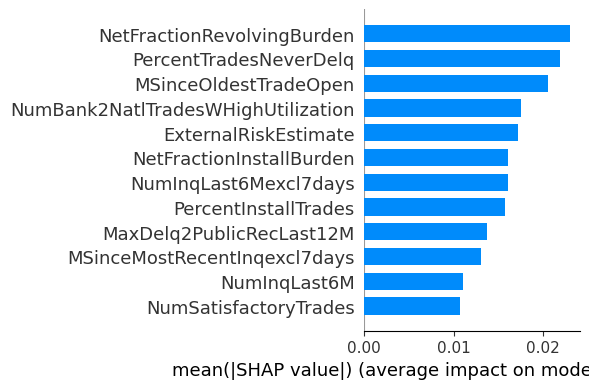

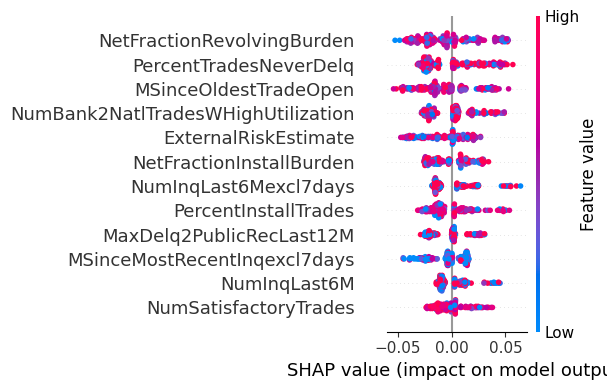

In [ ]:
import numpy as np
import shap
import torch

model.eval()  # important

# 1) prediction wrapper: numpy -> torch -> numpy
def model_predict(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        x_t = torch.tensor(x_np, dtype=torch.float32)
        y = model(x_t).cpu().numpy().reshape(-1)  # shape (n,)
    return y

# 2) pick a small background set (Kernel explainer is expensive)
bg = X_train_scaled[:200]          # numpy array
xt = X_test_scaled[:200]           # numpy array

# 3) use model-agnostic KernelExplainer via the unified API
explainer = shap.Explainer(model_predict, bg)   # SHAP picks Kernel under the hood
shap_values = explainer(xt)                     # works now

# 4) plots
import matplotlib.pyplot as plt

def small_shap_plot(plot_type=None):
    import matplotlib.pyplot as plt
    plt.close('all')
    shap.summary_plot(
        shap_values,
        features=X_test.iloc[:200],
        feature_names=X_test.columns,
        plot_type=plot_type,  # None = beeswarm, "bar" = bar plot
        max_display=12,
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    plt.tight_layout()
    plt.show()

small_shap_plot("bar")   # fig 1
small_shap_plot(None)    # fig 2 (beeswarm)


In [ ]:
import numpy as np
import torch
from lime.lime_tabular import LimeTabularExplainer

model.eval()

# numpy -> torch -> numpy, returns Nx2 proba matrix
def predict_proba_np(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        x_t = torch.tensor(x_np, dtype=torch.float32)
        p_bad = model(x_t).cpu().numpy().reshape(-1)      # sigmoid output
    p_good = 1.0 - p_bad
    return np.column_stack([p_good, p_bad])               # columns map to class_names order

# LIME must see the SAME feature space it will perturb; you used scaled data, so keep it
lime_explainer = LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=["Good", "Bad"],          # column 0 then 1 in predict_proba_np
    discretize_continuous=False,          # we already scaled; no binning games
    mode="classification"
)

i = 5
exp = lime_explainer.explain_instance(
    X_test_scaled[i],
    predict_proba_np,                      # <-- use wrapper, NOT raw model
    num_features=10
)

# Text output if you’re not in a notebook:
# print(exp.as_list())
explanation_df = pd.DataFrame(exp.as_list(), columns=["Feature", "Contribution"])
display(explanation_df)
# Or HTML in notebook: exp.show_in_notebook()



,Feature,Contribution
0,PercentTradesNeverDelq,-0.025683
1,MSinceOldestTradeOpen,-0.025295
2,ExternalRiskEstimate,-0.021231
3,NumBank2NatlTradesWHighUtilization,-0.020670
4,MSinceMostRecentTradeOpen,-0.019568
5,MaxDelq2PublicRecLast12M,-0.018746
6,NetFractionInstallBurden,-0.017190
7,NumSatisfactoryTrades,-0.014146
8,NumRevolvingTradesWBalance,-0.010785
9,AverageMInFile,-0.008718
